In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


df = pd.read_csv("Shoes_Data.csv")
df = df.drop_duplicates()
df['price'] = df.apply(lambda row: float(row.price[1:]), axis=1)
print(df.shape)
print(df.head(10))

(1015, 8)
                                               title  price  \
0    CLYMB Outdoor Sports Running Shoes for Mens Boy  279.0   
1              Bourge Men's Loire-z126 Running Shoes  479.0   
2                               T-Rock Men's Sneaker  430.0   
3  Robbie jones Sneakers Casual Canvas Fabric Col...  499.0   
4                       Sparx Men's Sd0323g Sneakers  499.0   
5        Inklenzo White Shoes for Mens for Daily USE  449.0   
6  Robbie jones White Men Casual Sneakers Shoes f...  499.0   
7                                 Knoos Men's Loafer  449.0   
8             BATA Men's Boss-ace Uniform Dress Shoe  559.0   
9                    road runner Men's Sneaker Shoes  399.0   

               rating  total_reviews  \
0  2.9 out of 5 stars   2389 ratings   
1  3.9 out of 5 stars  11520 ratings   
2  3.3 out of 5 stars   1251 ratings   
3  4.2 out of 5 stars      3 ratings   
4  4.2 out of 5 stars  20110 ratings   
5  3.5 out of 5 stars    224 ratings   
6  3.3 out of 5 

Идея: выделить все прилагательные из описания, затем посмотреть, какие встречаются почти везде, и посчитать количество "редких" эпитетов. 
Логика: если описание оригинальное, не похожее на остальные, спрос выше -> выше цена.

In [ ]:

from textblob import TextBlob


def get_adjectives(text):
    blob = TextBlob(text)
    return [ word for (word,tag) in blob.tags if tag == "JJ"]

def get_rare_adjectives(adjectives, adj_counter, threshold):
    return len([adj for adj in adjectives if adj_counter[adj] <= threshold])

Почистим описания перед выделением метрик.

In [ ]:
import re 
from string import punctuation
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words('english')
stop = set(stop)

def remove_punctuation(text):
    return text.translate(str.maketrans('','', punctuation))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop])

def remove_digits(text):
    return re.sub(r'\d+', '', text)

def remove_non_printable(text):
    text = text.encode("ascii", "ignore")
    return text.decode()
        
def clean_text(text):
    text = text.lower()
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = remove_digits(text)
    text = remove_non_printable(text)
    return text

[nltk_data] Downloading package stopwords to /Users/st/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Посмотрим так же длину описания в целом и просто число прилагательных (по гипотезе, эпитетов) в описании.

In [ ]:
from collections import Counter

df = df[['price', 'product_description']]
df["product_description"] = df["product_description"].apply(clean_text)
df['adjectives'] = df['product_description'].apply(get_adjectives)
adjectives_counter = Counter([adj for adj_list in df["adjectives"] for adj in adj_list])
adjectives_counter.most_common(15)

[('casual', 361),
 ('upper', 346),
 ('comfortable', 275),
 ('footwear', 249),
 ('perfect', 244),
 ('mesh', 200),
 ('stylish', 184),
 ('soft', 166),
 ('high', 152),
 ('formal', 136),
 ('sole', 132),
 ('great', 131),
 ('contemporary', 130),
 ('lightweight', 121),
 ('exceptional', 120)]

In [ ]:
df["adj_count"] = df['adjectives'].apply(len)
df["rare_adj_count"] = df["adjectives"].apply(get_rare_adjectives, threshold=10, adj_counter=adjectives_counter)
df["desc_len"] = df['product_description'].apply(len)
df[["price", "adjectives", "adj_count", "rare_adj_count", "desc_len"]].sort_values("price", ascending=False)

,price,adjectives,adj_count,rare_adj_count,desc_len
847,7992.0,"[add, routine, cross, smooth]",4,3,113
1192,7702.0,"[rubber, new, destined]",3,1,359
832,7621.0,"[new, first, basic, iconic, recycled, upper, r...",13,6,405
1196,7480.0,"[nike, soft, incredible, ultraresponsive]",4,1,371
1193,7256.0,"[react, surreal, vivid, exaggerated, react, fo...",7,6,182
...,...,...,...,...,...
47,155.0,"[light, rubber, sole, excellent, range, keep, ...",10,1,152
871,142.0,"[trendy, slipper, comfortable, durable, casual...",10,2,151
21,132.0,"[footwear, paralite, stylish, thong, light, co...",10,4,219
56,129.0,"[range, keep, great, light, flexible, comforta...",6,1,112


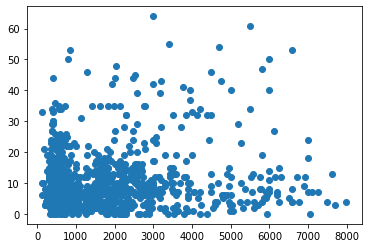

In [ ]:
plt.scatter(df['price'], df['adj_count'])
plt.show()

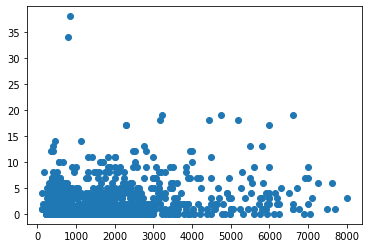

In [ ]:
plt.scatter(df['price'], df['rare_adj_count'])
plt.show()

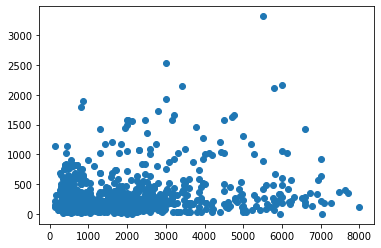

In [ ]:
plt.scatter(df['price'], df['desc_len'])
plt.show()

Теперь лемматизируем

In [ ]:

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[\w-]+')

from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
from collections import defaultdict
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

def lemmatize(line):
  tokens = tokenizer.tokenize(line)
  lemmas = []
  for token, tag in pos_tag(tokens):
      if len(token) > 1:
        lemma = lemmatizer.lemmatize(token.lower(), tag_map[tag[0]])
        if not re.search('[a-z]', token):
          lemmas.append(f'{lemma.upper()} {lemma}')
        else:
          lemmas.append(lemma)
  return ' '.join(lemmas)

df['lemmatized'] = [lemmatize(row) for row in df['product_description']]


[nltk_data] Downloading package wordnet to /Users/st/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import linear_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error


tfidf_vectorizer = TfidfVectorizer(analyzer='word')
bow_vectorizer = CountVectorizer()
X_tf_idf = tfidf_vectorizer.fit_transform(df['lemmatized'])
X_bow = bow_vectorizer.fit_transform(df['lemmatized'])

X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, df['price'], test_size=0.70, random_state=42)
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tf_idf, df['price'], test_size=0.70, random_state=42)


def predict(model, vectorizer, X_train, X_test, Y_train, Y_test):
    model = model.fit(X_train, Y_train)
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    print(f"Results on train set for {str(type(model)).rsplit('.', 1)[1][:-2]}, {vectorizer}: {mean_absolute_error(Y_train, train_preds)}" )
    print(f"Results on test set for {str(type(model)).rsplit('.', 1)[1][:-2]}, {vectorizer}: {mean_absolute_error(Y_test, test_preds)}" )


Линейная регрессия

In [ ]:
predict(linear_model.LinearRegression(), "Bag of words", X_train_bow, X_test_bow, y_train_bow, y_test_bow )
predict(linear_model.LinearRegression(), "tf-idf", X_train_tf, X_test_tf, y_train_tf, y_test_tf)


Results on train set for LinearRegression, Bag of words: 107.0953967524777
Results on test set for LinearRegression, Bag of words: 2680.763029500149
Results on train set for LinearRegression, tf-idf: 107.24547217382404
Results on test set for LinearRegression, tf-idf: 2110.8782738655536


In [ ]:
from sklearn.ensemble import RandomForestRegressor


predict(RandomForestRegressor(random_state=42), "Bag of words", X_train_bow, X_test_bow, y_train_bow, y_test_bow )
predict(RandomForestRegressor(random_state=42), "tf-idf", X_train_tf, X_test_tf, y_train_tf, y_test_tf)



Results on train set for RandomForestRegressor, Bag of words: 383.3247754815543
Results on test set for RandomForestRegressor, Bag of words: 837.5923901210135
Results on train set for RandomForestRegressor, tf-idf: 382.2185607197079
Results on test set for RandomForestRegressor, tf-idf: 861.5807735401418


In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

predict(make_pipeline(StandardScaler(with_mean=False), SVR(C=1.0, epsilon=0.2)), "Bag of words", X_train_bow, X_test_bow, y_train_bow, y_test_bow )
predict(make_pipeline(StandardScaler(with_mean=False), SVR(C=1.0, epsilon=0.2)), "tf-idf", X_train_tf, X_test_tf, y_train_tf, y_test_tf)



Results on train set for Pipeline, Bag of words: 1216.3092120246722
Results on test set for Pipeline, Bag of words: 1127.4319754245819
Results on train set for Pipeline, tf-idf: 1216.0497171615962
Results on test set for Pipeline, tf-idf: 1127.7106818541083


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor


predict(GradientBoostingRegressor(random_state=42), "Bag of words", X_train_bow, X_test_bow, y_train_bow, y_test_bow )
predict(GradientBoostingRegressor(random_state=42), "tf-idf", X_train_tf, X_test_tf, y_train_tf, y_test_tf)


Results on train set for GradientBoostingRegressor, Bag of words: 529.0033063301556
Results on test set for GradientBoostingRegressor, Bag of words: 894.1510058225228
Results on train set for GradientBoostingRegressor, tf-idf: 452.9094104451097
Results on test set for GradientBoostingRegressor, tf-idf: 937.7257760033043


Лучший результат у векторизации BoW, среди них на RFR и GBR. Будем подбирать параметры для них. 

In [32]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = {'n_estimators': [500, 700, 1000], 'max_depth': [None, 2, 3], 'min_samples_split': [2, 3]}
cv_random_forest = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv= 5).fit(X_train_bow, y_train_bow)

print(cv_random_forest.best_params_)
predict(RandomForestRegressor(random_state=42, **cv_random_forest.best_params_), "BoW", X_train_bow, X_test_bow, y_train_bow, y_test_bow)


{'max_depth': None, 'min_samples_split': 3, 'n_estimators': 500}
Results on train set for RandomForestRegressor, BoW: 378.3004584279219
Results on test set for RandomForestRegressor, BoW: 817.2562156067781


Для Gradient Boosting

In [33]:
parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "max_depth":[3,5,8],
    "criterion": ["mae"],
    "n_estimators":[10]
    }

cv_gradient_boosting = GridSearchCV(GradientBoostingRegressor(), parameters, cv=10, n_jobs=-1).fit(X_train_tf, y_train_tf)
print(cv_gradient_boosting.score(X_train_tf, y_train_tf))
print(cv_gradient_boosting.best_params_)
predict(GradientBoostingRegressor(random_state=42, **cv_gradient_boosting.best_params_), "tf-idf", X_train_tf, X_test_tf, y_train_tf, y_test_tf)


/Users/st/projects/liza/venv/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1850: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  warnings.warn(
/Users/st/projects/liza/venv/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1850: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  warnings.warn(
/Users/st/projects/liza/venv/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:1850: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  warnings.warn(
/Users/st/projects/liza/venv/lib/python3.9/site-packages/sklearn

Попробуем использовать выделенные фичи.

In [ ]:
import scipy as sp

with_features = sp.sparse.hstack((X_tf_idf, np.array([[row] for row in df['desc_len']])))
with_features = sp.sparse.hstack((with_features, np.array([[row] for row in df['adj_count']])))
with_features = sp.sparse.hstack((with_features, np.array([[row] for row in df['rare_adj_count']])))
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(with_features, df['price'], test_size=0.70, random_state=42)
predict(RandomForestRegressor(random_state=42, **cv_random_forest.best_params_), "Bag of words", X_train_bow, X_test_bow, y_train_bow, y_test_bow)


SyntaxError: positional argument follows keyword argument unpacking (194357978.py, line 7)